In [31]:
import torch 
from torch import nn 
from matplotlib import pyplot as plt 
%matplotlib inline
import numpy as np 
from pytorchsummary import summary #pip install pytorchsummary

Dataset

In [32]:
datapoints = np.array([[1,0],[1,1],
                       [0,0],[0,1]],dtype=np.float32)
datapoints,datapoints.shape

(array([[1., 0.],
        [1., 1.],
        [0., 0.],
        [0., 1.]], dtype=float32),
 (4, 2))

corresponding labels of the datapoints

In [33]:
labels = [1,0,0,1]

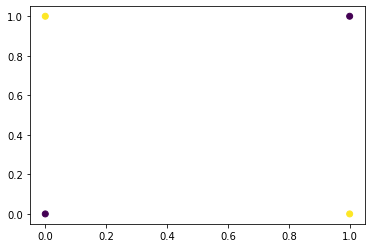

In [34]:
plt.scatter(datapoints[:,0],datapoints[:,1],c=labels)

Define a MLP in pytorch with `activation functions`

In [35]:
class Acti(nn.Module):
    def __init__(self,inputs,numclass) -> None:
        super(Acti,self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(inputs,2,bias=False),
            nn.Tanh(),
            nn.Linear(2,numclass,bias=False),
            nn.Tanh()

        )
    def forward(self,x):
        return self.nn(x)

activationModel = Acti(2,1)
summary((2,),activationModel),activationModel

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Linear-1	[1, 2]              	       [2, 2]       	4                   	(4+0)               	   True   
              Tanh-2	[1, 2]              	                    	                    	                    	          
            Linear-3	[1, 1]              	       [1, 2]       	2                   	(2+0)               	   True   
              Tanh-4	[1, 1]              	                    	                    	                    	          
______________________________________________________________________________________________________________________________________________________

Total parameters 6
Total Non-Trainable parameters 0
Total Trainable parameters 6


((6, 6, 0),
 Acti(
   (nn): Sequential(
     (0): Linear(in_features=2, out_features=2, bias=False)
     (1): Tanh()
     (2): Linear(in_features=2, out_features=1, bias=False)
     (3): Tanh()
   )
 ))

```c++
output = Model(input)
```

In [36]:
Xs = torch.tensor(datapoints) # changing numpy nd.array to pytorch tensors
o_acti = activationModel(Xs)
o_acti

tensor([[ 0.1287],
        [ 0.0527],
        [ 0.0000],
        [-0.0758]], grad_fn=<TanhBackward0>)

In [37]:
o_acti.shape

torch.Size([4, 1])

In [38]:
def plot(array,labels):
    fig = plt.figure(figsize=(6,6))
    plt.scatter(array[:,0].detach().numpy(),np.zeros_like(array[:,0].detach().numpy()),c=labels)

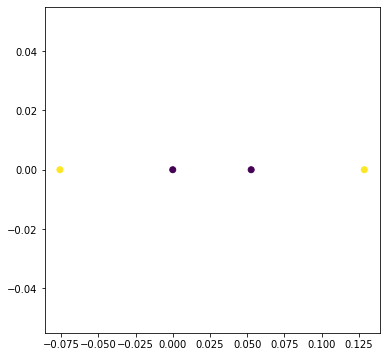

In [39]:
plot(o_acti,labels)

Defining a MLP with `NO Activation functions`

In [40]:
class NoActi(nn.Module):
    def __init__(self,inputs,numclass) -> None:
        super(NoActi,self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(inputs,2,bias=False),
            nn.Linear(2,numclass,bias=False),
        )
    
    def forward(self,x):
        return self.nn(x)

NoactivationModel = NoActi(2,1)
summary((2,),NoactivationModel),NoactivationModel

               Layer	Output Shape        	    Kernal Shape    	#params             	#(weights + bias)   	requires_grad
------------------------------------------------------------------------------------------------------------------------------------------------------
            Linear-1	[1, 2]              	       [2, 2]       	4                   	(4+0)               	   True   
            Linear-2	[1, 1]              	       [1, 2]       	2                   	(2+0)               	   True   
______________________________________________________________________________________________________________________________________________________

Total parameters 6
Total Non-Trainable parameters 0
Total Trainable parameters 6


((6, 6, 0),
 NoActi(
   (nn): Sequential(
     (0): Linear(in_features=2, out_features=2, bias=False)
     (1): Linear(in_features=2, out_features=1, bias=False)
   )
 ))

```python
Output = model_with_noactivation(input)
```

In [41]:
o_noacti = NoactivationModel(Xs)
o_noacti

tensor([[ 0.1208],
        [-0.1923],
        [ 0.0000],
        [-0.3131]], grad_fn=<MmBackward0>)

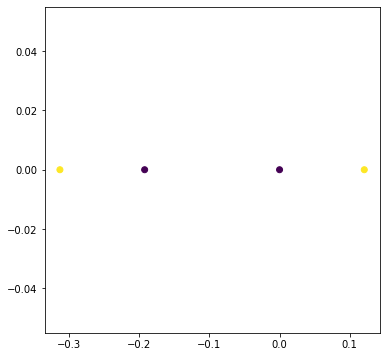

In [42]:
plot(o_noacti,labels)

# Training these two MLPS

In [43]:
LOSS =nn.BCEWithLogitsLoss()
noActi_optim = torch.optim.SGD(NoactivationModel.parameters(),lr=0.1)
acti_optim = torch.optim.SGD(activationModel.parameters(),lr=0.1)

In [44]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self) -> None:
        self.data = Xs
        self.targets = torch.tensor(labels,dtype=torch.float)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
         return self.data[index],self.targets[index]

In [45]:
dataset = Dataset()
loader = torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True)


### Training function

In [46]:
from tqdm.notebook import tqdm 

def training(trainloader,model1,model2,lossfn,optim1,optim2,epoch):
    def noactitrain(trainloader,model1,lossfn,optim1):
        for x,y in trainloader:
            y=y.unsqueeze(1)
            optim1.zero_grad()
            yhat = model1(x)
            batchloss = lossfn(yhat,y)
            batchloss.backward()
            optim1.step()
        return batchloss.item()

    def actitrain(trainloader,model2,lossfn,optim2):
        
        for x,y in trainloader:
            y=y.unsqueeze(1)
            optim2.zero_grad()
            yhat = model2(x)
            batchloss = lossfn(yhat,y)
            batchloss.backward()
            optim2.step()
        return batchloss.item()
    
    nosigLOSS = list()
    sigLOSS = list()
    for e in tqdm(range(epoch)):
        nosigLOSS.append(noactitrain(trainloader,model1,lossfn,optim1))
    for e in tqdm(range(epoch)):
        sigLOSS.append(actitrain(trainloader,model2,lossfn,optim2))
    
    plt.plot(range(epoch),sigLOSS,label='WITH activations')
    plt.plot(range(epoch),nosigLOSS,color='r',label='WITHOUT activations')
    plt.legend()
    plt.show()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

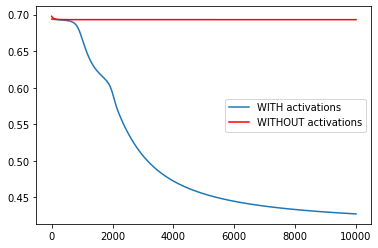

In [47]:
training(loader,NoactivationModel,activationModel,LOSS,noActi_optim,acti_optim,10000)

Model with No Activation function

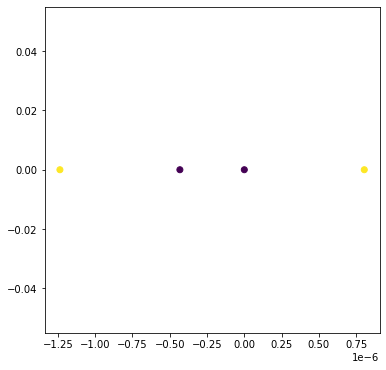

In [48]:
plot(NoactivationModel(Xs),labels)

Model with activation function

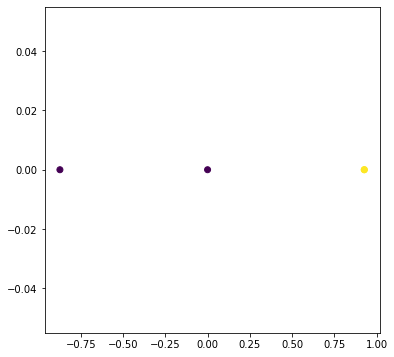

In [49]:
plot(activationModel(Xs),labels)

In [50]:
for i,p in enumerate(NoactivationModel.parameters()):
    print(f'Layer {i} | Shape of the weight: ',p.shape)

Layer 0 | Shape of the weight:  torch.Size([2, 2])
Layer 1 | Shape of the weight:  torch.Size([1, 2])


In [51]:
for i,p in enumerate(activationModel.parameters()):
    print(f'Layer {i} | Shape of the weight: ',p.shape)

Layer 0 | Shape of the weight:  torch.Size([2, 2])
Layer 1 | Shape of the weight:  torch.Size([1, 2])


In [52]:
for p in activationModel.parameters():
    print(p)

Parameter containing:
tensor([[ 0.4683,  0.4685],
        [-3.2084, -3.2649]], requires_grad=True)
Parameter containing:
tensor([[-10.1191,  -6.0773]], requires_grad=True)


# Activation model

In [53]:
activationModel(Xs)

tensor([[ 0.9271],
        [-0.8735],
        [ 0.0000],
        [ 0.9271]], grad_fn=<TanhBackward0>)

In [54]:
W0=activationModel.nn[0].weight.detach()
W1=activationModel.nn[2].weight.detach()
W0,W0.shape,W1,W1.shape

(tensor([[ 0.4683,  0.4685],
         [-3.2084, -3.2649]]),
 torch.Size([2, 2]),
 tensor([[-10.1191,  -6.0773]]),
 torch.Size([1, 2]))

In [55]:
Xs,Xs.T

(tensor([[1., 0.],
         [1., 1.],
         [0., 0.],
         [0., 1.]]),
 tensor([[1., 1., 0., 0.],
         [0., 1., 0., 1.]]))

In [56]:
a1 = torch.matmul(W0,Xs.T)
print(a1,a1.shape)
a1 = torch.tanh(a1)
a2 = torch.matmul(W1,a1)
torch.tanh(a2)

tensor([[ 0.4683,  0.9368,  0.0000,  0.4685],
        [-3.2084, -6.4733,  0.0000, -3.2649]]) torch.Size([2, 4])


tensor([[ 0.9271, -0.8735,  0.0000,  0.9271]])

# No Activation

In [57]:
NoactivationModel(Xs)

tensor([[ 8.0466e-07],
        [-4.3213e-07],
        [ 0.0000e+00],
        [-1.2368e-06]], grad_fn=<MmBackward0>)

In [58]:
_w0 = NoactivationModel.nn[0].weight.detach()
_w1 = NoactivationModel.nn[1].weight.detach()
_w0,_w1

(tensor([[-0.0664,  0.2400],
         [-0.0371,  0.1341]]),
 tensor([[-0.3866,  0.6918]]))

tensor([[-0.0664,  0.1736,  0.0000,  0.2400],
        [-0.0371,  0.0970,  0.0000,  0.1341]])


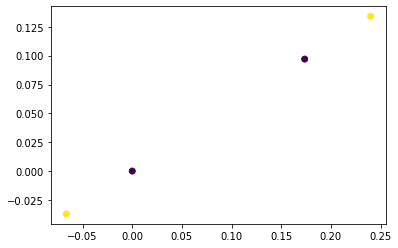

In [59]:
_a1 = torch.matmul(_w0,Xs.T)
print(_a1)
plt.scatter(_a1[0,:].numpy(),_a1[1,:].numpy(),c=labels)
# plt.axline((0, 0), slope=(-0.0503/-0.3508), color="yellow", linestyle='--')
# plt.axline((0, 0), slope=(-0.1591/-0.6467), color="yellow", linestyle='--')


(tensor([[ 8.0391e-07, -4.3458e-07,  0.0000e+00, -1.2392e-06]]),
 torch.Size([1, 4]),
 <matplotlib.collections.PathCollection at 0x227f97549d0>)

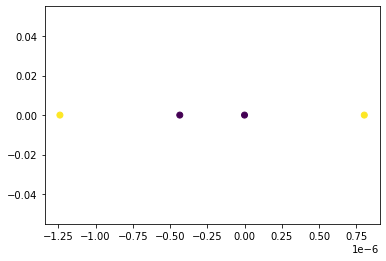

In [60]:
_a2 = torch.matmul(_w1,_a1)
_a2,_a2.shape,plt.scatter(_a2[0],[0]*4,c=labels)